# Constructiveness by topic in the comments

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re, math, os
import operator
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
TOPIC_MODELLING_DIR = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/Topic_Modelling/'
DATA_DIR = '/Users/vasundhara/sfuvault/Discourse-Lab/Data/'

THRESHOLD_PROBABILITY = 0.10

SAVE = True
SAVE_FOLDER = 'TACT/img/topics_constructiveness/'
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [3]:
def plotAgainstTopics(x,y):
    sns.set_context('talk')
    sns.set(rc={'figure.figsize':(12,8)})

    fig,ax = plt.subplots(1,1)
    sns.barplot(x, y)#, s=100)
    ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']
    plt.xlabel('Topics', fontsize=20)
    plt.ylabel('Average constructiveness', fontsize=20)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    plt.ylim([0,0.7])
    ax.tick_params(axis='both', which='major', labelsize=13)
    plt.tight_layout()

    return fig

In [4]:
def getPlottableDataFrame(merged):

    topic_counts = [0] * 15
    topic_constructiveness = [0] * 15

    def getCountsAndConstructiveness(merged_row):
        topic_probabilities = eval(merged_row['topic_probabilities'])

        for topic_prob in topic_probabilities:
            if topic_prob[1] > THRESHOLD_PROBABILITY:
                topic_counts[topic_prob[0]] += 1
                topic_constructiveness[topic_prob[0]] += merged_row['bilstm_prediction']

    merged.apply(getCountsAndConstructiveness, axis=1)

    to_plot = (pd.DataFrame(topic_constructiveness) / pd.DataFrame(topic_counts)).reset_index().rename({'index' : 'x', 0 : 'y'}, axis=1)
    
    return to_plot

## SOCC

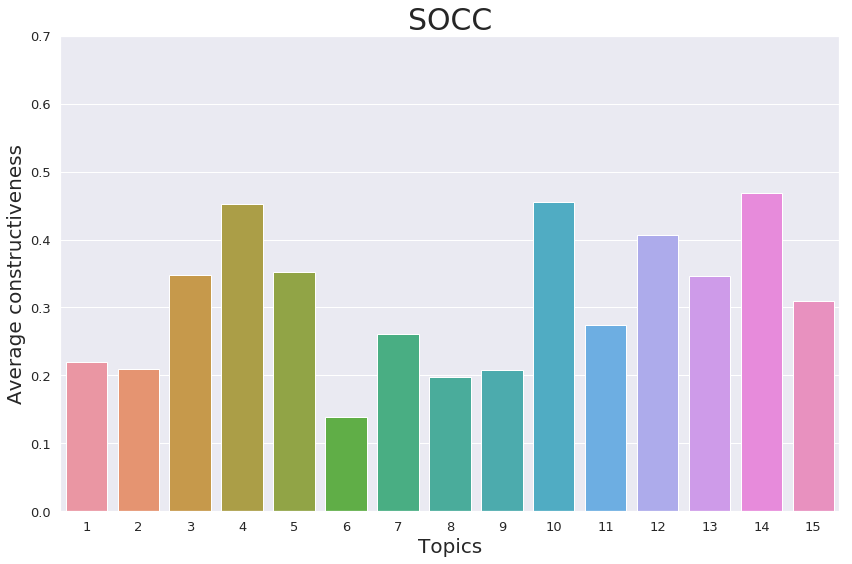

In [5]:
socc_constructiveness = pd.read_csv('/Users/vasundhara/sfuvault/Discourse-Lab/Data/Globe_and_Mail/Globe_analysis/socc_constructiveness_predictions.csv')
socc_predictions = pd.read_csv(TOPIC_MODELLING_DIR+'/results/socc_comments_topics.txt',
                               sep=';', header=None, index_col=0).rename({1 : 'topic_probabilities'},
                                                                         axis=1).reset_index(drop=True)

assert len(socc_constructiveness) == len(socc_predictions)

socc_merged = socc_predictions.merge(socc_constructiveness, left_index=True, right_index=True)

to_plot = getPlottableDataFrame(socc_merged)
fig = plotAgainstTopics(to_plot['x'], to_plot['y'])

plt.title('SOCC', fontsize=30)
plt.tight_layout()

if SAVE:
    plt.savefig(SAVE_FOLDER+'/SOCC.png')
else:
    plt.show()

## The Tyee

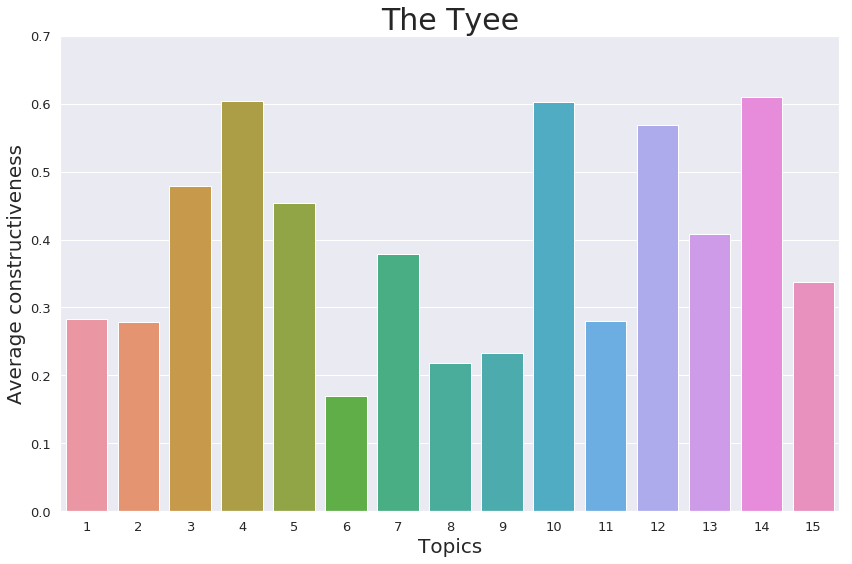

In [6]:
tyee_constructiveness = pd.read_csv('/Users/vasundhara/sfuvault/Discourse-Lab/Data/The_Tyee_data/Tyee analysis/tyee_constructiveness_results.csv')
tyee_predictions = pd.read_csv(TOPIC_MODELLING_DIR+'/results/tyee_comments_topics.txt',
                               sep=';', header=None, index_col=0).rename({1 : 'topic_probabilities'},
                                                                         axis=1).reset_index(drop=True)
tyee_comments = pd.read_csv('/Users/vasundhara/sfuvault/Discourse-Lab/Data/The_Tyee_data/CSVs/the_tyee_posts_preprocessed.csv',
            low_memory=False).dropna(subset=['message_preprocessed']).reset_index(drop=True)

merged = tyee_comments.merge(tyee_predictions, left_index=True, right_index=True)
tyee_merged = tyee_constructiveness.merge(merged, left_on=['post_id', 'thread_id', 'comment_text'],
                                          right_on=['post_id', 'thread_id', 'message_preprocessed'],
                                          how='inner').drop_duplicates(subset=['post_id',
                                                                               'thread_id',
                                                                               'id',
                                                                               'message_preprocessed'])

to_plot = getPlottableDataFrame(tyee_merged)
fig = plotAgainstTopics(to_plot['x'], to_plot['y'])

plt.title('The Tyee', fontsize=30)
plt.tight_layout()

if SAVE:
    plt.savefig(SAVE_FOLDER+'/The_Tyee.png')
else:
    plt.show()

## The Conversation

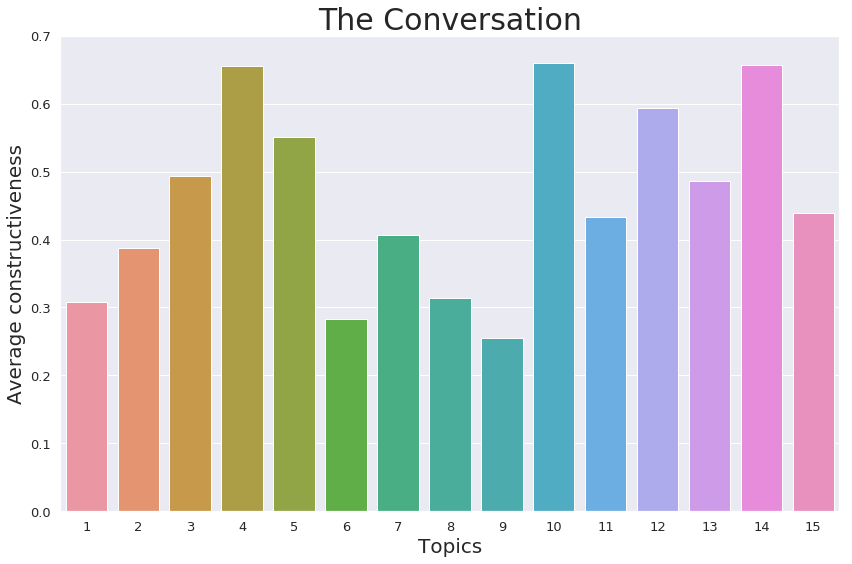

In [7]:
conv_constructiveness = pd.read_csv('/Users/vasundhara/sfuvault/Discourse-Lab/Data/The_Conversation_data/Conversation analysis/conversation_constructiveness_results.csv').dropna()
conv_predictions = pd.read_csv(TOPIC_MODELLING_DIR+'/results/conv_comments_topics.txt',
                               sep=';', header=None, index_col=0).rename({1 : 'topic_probabilities'},
                                                                         axis=1).reset_index(drop=True).drop(11213, axis=0)

assert len(conv_constructiveness) == len(conv_predictions)

conv_merged = conv_predictions.merge(conv_constructiveness, left_index=True, right_index=True)

to_plot = getPlottableDataFrame(conv_merged)
fig = plotAgainstTopics(to_plot['x'], to_plot['y'])

plt.title('The Conversation', fontsize=30)
plt.tight_layout()

if SAVE:
    plt.savefig(SAVE_FOLDER+'/The_Conversation.png')
else:
    plt.show()

## All comments

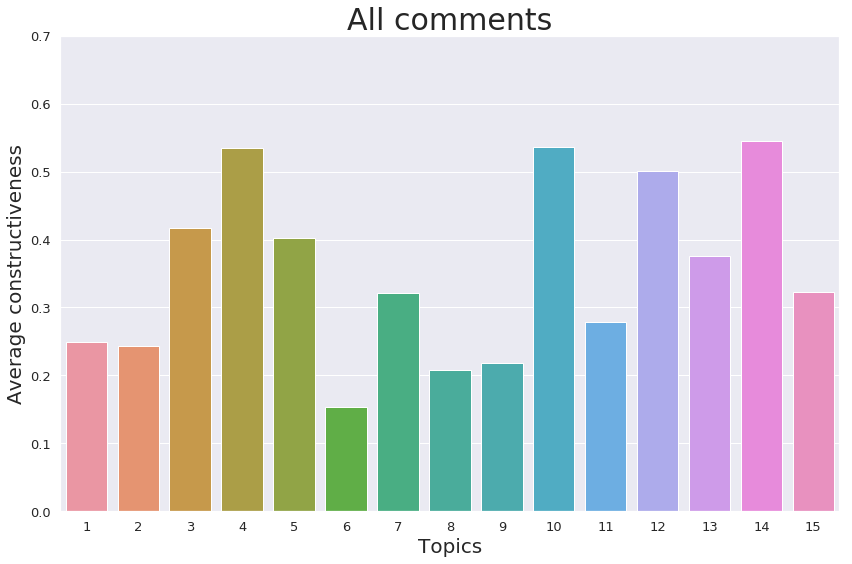

In [8]:
corpora = [conv_merged, socc_merged, tyee_merged]
all_corpora = pd.concat(corpora, axis=0, ignore_index=True, sort=False)

to_plot = getPlottableDataFrame(all_corpora)
fig = plotAgainstTopics(to_plot['x'], to_plot['y'])

plt.title('All comments', fontsize=30)
plt.tight_layout()

if SAVE:
    plt.savefig(SAVE_FOLDER+'/All_comments.png')
else:
    plt.show()

## TukeyHSD exploration

In [9]:
var_val_pairs = []

for i,row in all_corpora.iterrows():
    topic_probabilities = eval(row['topic_probabilities'])
    
    for topic_prob in topic_probabilities:
            if topic_prob[1] > THRESHOLD_PROBABILITY:
                var_val_pairs.append(['topic'+str(topic_prob[0]+1), round(row['bilstm_prediction']*100)])

In [10]:
df = pd.DataFrame(var_val_pairs, columns=['variable', 'value'])

In [11]:
posthoc = pairwise_tukeyhsd(df['value'], df['variable'])

In [12]:
print(posthoc.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper   reject
-------------------------------------------------
 topic1 topic10 28.7124  28.1823  29.2424   True 
 topic1 topic11  2.8531   2.0778   3.6284   True 
 topic1 topic12 25.1136  24.5578  25.6695   True 
 topic1 topic13  12.615  11.9734  13.2565   True 
 topic1 topic14 29.5896  29.0614  30.1177   True 
 topic1 topic15  7.2649   6.604    7.9258   True 
 topic1  topic2 -0.6807   -1.388   0.0266  False 
 topic1  topic3 16.7976  16.2091  17.3862   True 
 topic1  topic4 28.5349  28.0011  29.0687   True 
 topic1  topic5 15.2945  14.7166  15.8723   True 
 topic1  topic6 -9.5551  -10.4907 -8.6194   True 
 topic1  topic7  7.1676   6.5542   7.7811   True 
 topic1  topic8  -4.223  -5.1076  -3.3384   True 
 topic1  topic9  -3.084  -3.8714  -2.2965   True 
topic10 topic11 -25.8593 -26.4673 -25.2512  True 
topic10 topic12 -3.5988  -3.8774  -3.3201   True 
topic10 topic13 -16.0974 -16.522  -15.6728  True 

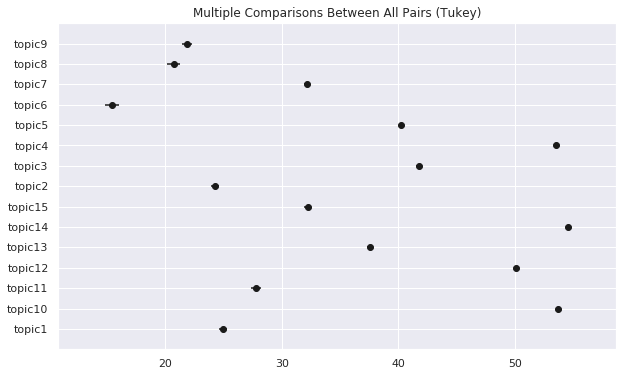

In [13]:
TukeyHSD = posthoc.plot_simultaneous()